In [2]:
# Description : This notebook is focused on building an artificial recurrent neural network calles LSTM 
# (Long Short Term Memory) to predict the closing price of a corporation using the past 60 days data. 

In [4]:
import math
import pandas as pd
import numpy as np
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
import yfinance as yf

In [86]:
today = date.today().strftime("%Y-%m-%d")
df = yf.download('AAPL','2015-01-01',today)

[*********************100%***********************]  1 of 1 completed


In [87]:
print(f"Shape : {df.shape}")
print(df.tail())
print(df.info())

Shape : (1606, 6)
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-05-12  123.400002  124.639999  122.250000  122.769997  122.769997   
2021-05-13  124.580002  126.150002  124.260002  124.970001  124.970001   
2021-05-14  126.250000  127.889999  125.849998  127.449997  127.449997   
2021-05-17  126.820000  126.930000  125.169998  126.269997  126.269997   
2021-05-18  126.559998  126.989998  124.779999  124.849998  124.849998   

               Volume  
Date                   
2021-05-12  112172300  
2021-05-13  105861300  
2021-05-14   81806500  
2021-05-17   74244600  
2021-05-18   63130600  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1606 entries, 2014-12-31 to 2021-05-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1606 non-null   float64
 1   High       1606 non-null   float64
 2   Low   

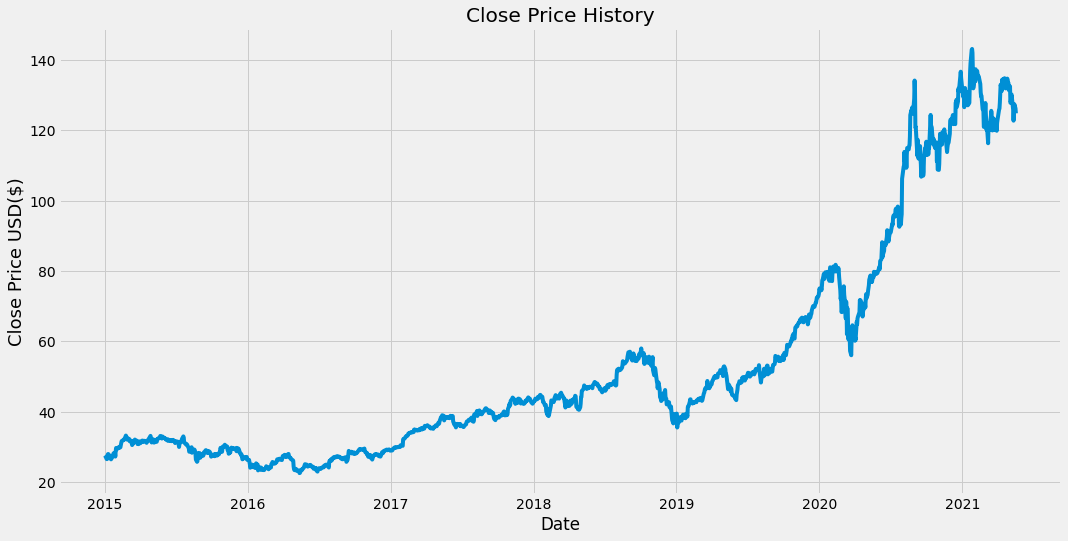

In [88]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show()

In [89]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

1285

In [90]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
print(f"Raw Data : \n{dataset}")
print(f"Scaled Data : \n{scaled_data}")

Raw Data : 
[[ 27.59499931]
 [ 27.33250046]
 [ 26.5625    ]
 ...
 [127.44999695]
 [126.26999664]
 [124.84999847]]
Scaled Data : 
[[0.0415509 ]
 [0.03937384]
 [0.03298777]
 ...
 [0.8697076 ]
 [0.85992116]
 [0.84814427]]


In [91]:
train_data = scaled_data[0:training_data_len,:]
x_train = []
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [92]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1225, 60, 1)

In [93]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [94]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [95]:
model.fit(x_train,y_train,batch_size=1,epochs=1)

1225/1225 [==============================] - 20s 15ms/step - loss: 7.9784e-04


In [96]:
test_data = scaled_data[training_data_len-60:,:]
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [97]:
x_test = np.array(x_test)

In [98]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [99]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [100]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1.131158181068682

<ipython-input-101-7aa66b8d0b79>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


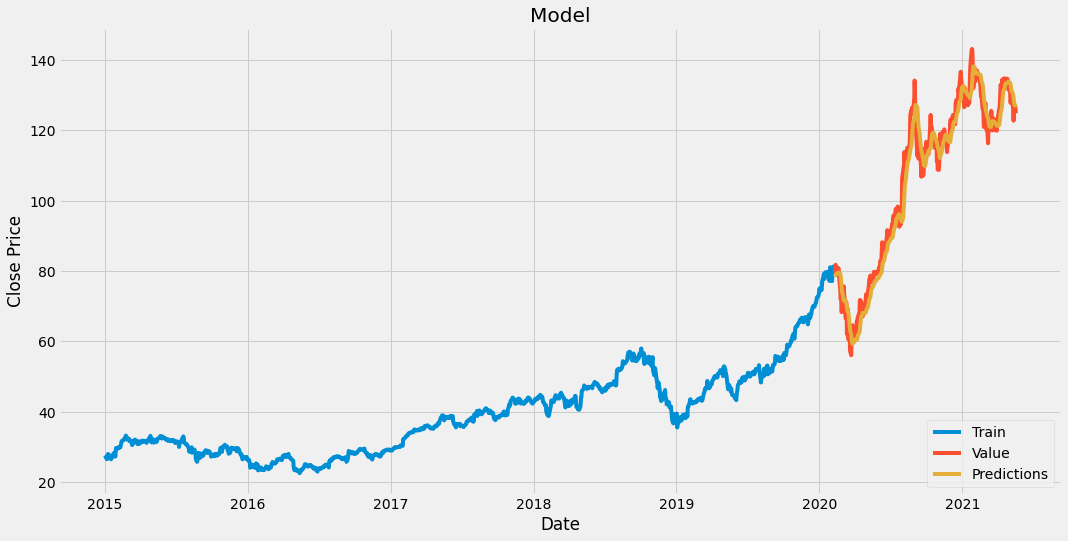

In [101]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Value','Predictions'],loc='lower right')
plt.show()

In [102]:
valid

Close  Predictions
Date                               
2020-02-10   80.387497    78.447266
2020-02-11   79.902496    78.642517
2020-02-12   81.800003    78.758759
2020-02-13   81.217499    79.019096
2020-02-14   81.237503    79.268478
...                ...          ...
2021-05-12  122.769997   129.336533
2021-05-13  124.970001   128.261932
2021-05-14  127.449997   127.369087
2021-05-17  126.269997   126.921707
2021-05-18  124.849998   126.630745

[321 rows x 2 columns]